In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
data = load_coco_data(pca_features=False)

In [4]:
def show_image(batch_size):
    captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()    

In [5]:
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_image_idxs <class 'numpy.ndarray'> (400135,) int32
idx_to_word <class 'list'> 1004
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_features <class 'numpy.ndarray'> (82783, 4096) float32
word_to_idx <class 'dict'> 1004
val_captions <class 'numpy.ndarray'> (195954, 17) int32
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_features <class 'numpy.ndarray'> (40504, 4096) float32
val_urls <class 'numpy.ndarray'> (40504,) <U63
word_embedding <class 'numpy.ndarray'> (1004, 304) float64


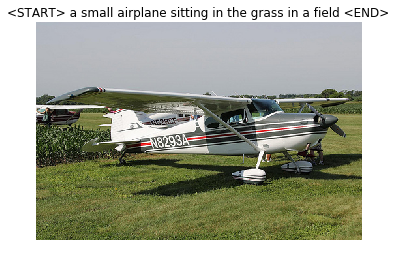

In [6]:
show_image(1)

In [7]:
def group_image_index_by_image_id(image_ids_in_caption_data_order):
    """
        Group image index, which is the same index position as corresponding caption data, by image id.
        i.e {8731 : [0,60,99,305]} caption and image features at these 4 positions correspond to image id 8731
    """
    image_positions_by_image_id = {}
    for i, img_id in enumerate(image_ids_in_caption_data_order):
        if img_id in image_positions_by_image_id:
            image_positions_by_image_id[img_id].append(i)
        else:
            image_positions_by_image_id[img_id] = [i]
    return image_positions_by_image_id

def map_image_index_to_captions(caption_data, grouped_image_index):
    """
        For each image id "key", get its corresponding captions, retrieved by "value" of the image instance indices.
        Image instance indices is assumed to be in the same order as the caption data.
    """
    captions_by_image_id = {}
    for k, v in grouped_image_index.items():
        captions_by_image_id[k] = caption_data[v]
    return captions_by_image_id

def scramble_image_caption_pairs(caption_data, grouped_image_index):    
    to_shuffle_caption = np.copy(caption_data)
    np.random.shuffle(to_shuffle_caption)
    return map_image_index_to_captions(to_shuffle_caption, grouped_image_index)

def flatten_image_caption_groups(grouped_captions):
    all_captions = []
    all_image_ids = []
    for k, v in grouped_captions.items():
        all_image_ids += [k] * len(v) # duplicate lables
        all_captions.append(v)
    flat_image_ids = np.array(all_image_ids)
    flat_captions = np.concatenate(all_captions, axis=0)
    assert flat_image_ids.shape[0] == flat_captions.shape[0]
    return flat_image_ids, flat_captions

def merge_demo_sampled(demo_image, demo_caption, sample_image, sample_caption):
    is_demo = np.ones(demo_image.shape)
    is_sample = np.ones(sample_image.shape) * -1
    return np.concatenate([demo_image, sample_image], axis=0), np.concatenate([demo_caption, sample_caption], axis=0), np.concatenate([is_demo, is_sample], axis=0)

def remove_start_token(captions_with_start_token):
    return np.array([c[1:] for c in captions_with_start_token])


In [8]:
# minibatch
class MiniBatcher(object):
    def __init__(self, batchable_tuple):
        shapes = [b.shape[0] for b in batchable_tuple]
        assert all([s == shapes[0] for s in shapes]), "Data to be batched together should have the same first dimension"
        self.batchable_tuple = batchable_tuple
        self.data_size = shapes[0]
    
    def sample(self, batch_size=100):
        assert batch_size <= self.data_size
        mask = np.random.choice(self.data_size, batch_size)
        batch_list = [b[mask] for b in self.batchable_tuple]
        return tuple(batch_list)

In [9]:
image_ids = data['train_image_idxs']
captions = data['train_captions']
idx_to_word = data['idx_to_word']

# create random pairing
grouped_image_index = group_image_index_by_image_id(image_ids)
grouped_captions = map_image_index_to_captions(captions, grouped_image_index)
scrambled_captions = scramble_image_caption_pairs(captions, grouped_image_index)

# merge both, and retain flag
image_idx_demo, captions_demo = flatten_image_caption_groups(grouped_captions)
image_idx_sampled, caption_sampled = flatten_image_caption_groups(scrambled_captions)

demo_batcher = MiniBatcher((image_idx_demo, captions_demo, np.ones(image_idx_demo.shape)))
sample_batcher = MiniBatcher((image_idx_sampled, caption_sampled, np.ones(image_idx_sampled.shape) * -1))

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import layer_utils 

## Model Param

In [11]:

## word preprocess
vocab_dim = len(data['word_to_idx'])
image_feature_dim = data['val_features'].shape[1]
enable_preprocessed_embedding = True

if enable_preprocessed_embedding:
    word_embedding_dim = data['word_embedding'].shape[1]
else:
    word_embedding_dim = 256

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NULL_TOKEN = '<NULL>'
UNK_TOKEN = '<UNK>'
NULL_ID = data['word_to_idx'][NULL_TOKEN]
START_ID = data['word_to_idx'][START_TOKEN]
END_ID = data['word_to_idx'][END_TOKEN]
UNK_ID = data['word_to_idx'][UNK_TOKEN]

## model params
hidden_dim = 512
learning_rate = 1e-3

print("Vocab Dim: %i\nImage Feature Dim: %i\nWord Embedding Dim: %i"%(vocab_dim, image_feature_dim, word_embedding_dim))

Vocab Dim: 1004
Image Feature Dim: 4096
Word Embedding Dim: 304


## Model Architecture

In [12]:
# Word Input


sy_caption_input = tf.placeholder(shape=[None, None], name="caption_input", dtype=tf.int32)

if enable_preprocessed_embedding:
    embedding_init = tf.constant(data['word_embedding'], dtype=tf.float32)
    embedding = tf.get_variable("embedding", initializer=embedding_init)
else:
    embedding_init = tf.random_normal_initializer()
    embedding = tf.get_variable("embedding", [vocab_dim, word_embedding_dim], dtype=tf.float32, initializer=embedding_init)

word_embedding = tf.nn.embedding_lookup(embedding, sy_caption_input)

# Image Input
sy_image_feat_input = tf.placeholder(shape=[None, image_feature_dim], name="image_feat_input", dtype=tf.float32)
image_projection = layer_utils.affine_transform(sy_image_feat_input, hidden_dim, 'image_proj')
initial_cell_state = image_projection * 0

# LSTM states
sy_hidden_state = tf.placeholder(shape=[None, hidden_dim], name="hidden_lstm_state", dtype=tf.float32)
sy_cell_state = tf.placeholder(shape=[None, hidden_dim], name="cell_lstm_state", dtype=tf.float32)

sy_is_initial_step = tf.placeholder(tf.int32, shape=[], name="is_initial_step")

initial_lstm_state = tf.nn.rnn_cell.LSTMStateTuple(image_projection * 0, image_projection)

In [13]:
# LSTM

use_bidirectional = False
if use_bidirectional:
    cell_fw = tf.nn.rnn_cell.LSTMCell(hidden_dim)
    cell_bw = tf.nn.rnn_cell.LSTMCell(hidden_dim)
    bi_output, _ = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, word_embedding, initial_state_bw=initial_lstm_state, initial_state_fw=initial_lstm_state, time_major=False, dtype=tf.float32)
    lstm_output = tf.concat([bi_output[0], bi_output[1]], axis=2)
else:
    cell = tf.nn.rnn_cell.LSTMCell(hidden_dim)
    lstm_output, output_cell_state = tf.nn.dynamic_rnn(cell, word_embedding, time_major=False, dtype=tf.float32, initial_state=initial_lstm_state)

# incremental_change = layer_utils.difference_over_time(lstm_output, "incremental_change")
hidden_to_reward = tf.squeeze(layer_utils.affine_transform(lstm_output, 1, 'hidden_to_reward'), axis=2)
# hidden_to_reward = tf.squeeze(layer_utils.build_mlp(lstm_output, 1, 'hidden_to_reward', activation=tf.nn.relu), axis=2)


# Apply not-null mask to ignore reward on trailing padding
sy_not_null_mask = tf.placeholder(shape=[None, None], name="mask_not_null", dtype=tf.bool)
sy_is_demo = tf.placeholder(shape=[None], name="is_demo", dtype=tf.float32)
expanded_is_demo = tf.expand_dims(sy_is_demo, dim=1)
numeric_mask_not_null = tf.cast(sy_not_null_mask, dtype=tf.float32)
masked_reward = hidden_to_reward * numeric_mask_not_null
negated_sample_reward = expanded_is_demo * masked_reward # the higher reward to demo, the lower reward to sampled
total_not_null = tf.cast(tf.reduce_sum(numeric_mask_not_null, axis=1), tf.float32)
mean_reward_for_each_sentence = tf.reduce_sum(negated_sample_reward, axis=1) / total_not_null
mean_reward = tf.reduce_mean(mean_reward_for_each_sentence)

update_op = tf.train.AdamOptimizer(learning_rate).minimize(mean_reward * -1) # maximize the reward

print("-- Input tensors --")
print("word embedding shape: ", word_embedding)
# print("bidiretional output layer: ", bi_output)
print("lstm_output output: ", lstm_output)
print("hidden reward: ", hidden_to_reward)

print("\n-- Loss tensors --")
print("Mask not null: ", numeric_mask_not_null)
print("Is demo null: ", sy_is_demo)
print("Total not null: ", total_not_null)
print("Masked reward: ", masked_reward)
print("Negated sample reward: ", masked_reward)
print("Mean reward for each sentence: ", masked_reward)
print("Mean reward: ",  mean_reward)


-- Input tensors --
word embedding shape:  Tensor("embedding_lookup:0", shape=(?, ?, 304), dtype=float32)
lstm_output output:  Tensor("rnn/transpose:0", shape=(?, ?, 512), dtype=float32)
hidden reward:  Tensor("Squeeze:0", shape=(?, ?), dtype=float32)

-- Loss tensors --
Mask not null:  Tensor("Cast:0", shape=(?, ?), dtype=float32)
Is demo null:  Tensor("is_demo:0", shape=(?,), dtype=float32)
Total not null:  Tensor("Sum:0", shape=(?,), dtype=float32)
Masked reward:  Tensor("mul_2:0", shape=(?, ?), dtype=float32)
Negated sample reward:  Tensor("mul_2:0", shape=(?, ?), dtype=float32)
Mean reward for each sentence:  Tensor("mul_2:0", shape=(?, ?), dtype=float32)
Mean reward:  Tensor("Mean:0", shape=(), dtype=float32)


## Training

In [14]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [15]:
def get_image_features(image_ids):
    return data['train_features'][image_ids]

def process_mini_batch(batcher1, batcher2, batch_size):
    image_idx_batch1, caption_batch1, demo_or_sampled_batch1 = batcher1.sample(batch_size)
    image_idx_batch2, caption_batch2, demo_or_sampled_batch2 = batcher2.sample(batch_size)
    image_idx_batch = np.concatenate([image_idx_batch1, image_idx_batch2], axis=0)
    caption_batch = np.concatenate([caption_batch1, caption_batch2], axis=0)
    
    demo_or_sampled_batch = np.concatenate([demo_or_sampled_batch1, demo_or_sampled_batch2], axis=0)
    not_null_mask_batch = caption_batch != NULL_ID
    # to randomize here
    
    return image_idx_batch, caption_batch, not_null_mask_batch, demo_or_sampled_batch

iter_num = 400
batch_size = 1000
for i in range(iter_num):
    
    image_idx_batch, caption_batch, not_null_mask, demo_or_sampled_batch = process_mini_batch(
        demo_batcher, 
        sample_batcher,
        batch_size
    )
    image_feats_batch = get_image_features(image_idx_batch)

    _, r, m, me = sess.run([update_op, mean_reward, negated_sample_reward, mean_reward_for_each_sentence], feed_dict=
                       {sy_image_feat_input: image_feats_batch,
                        sy_caption_input: caption_batch, 
                        sy_not_null_mask: not_null_mask,
                        sy_is_demo: demo_or_sampled_batch
                       })
    if i % 20 == 0:
        print("iter {}, reward: {}".format(i,r))

iter 0, reward: -0.0008303048671223223
iter 20, reward: 0.4212191104888916
iter 40, reward: 4.47576379776001
iter 60, reward: 10.658876419067383
iter 80, reward: 17.378387451171875
iter 100, reward: 22.463613510131836
iter 120, reward: 27.824562072753906
iter 140, reward: 34.14657974243164
iter 160, reward: 38.790462493896484
iter 180, reward: 46.20775604248047
iter 200, reward: 51.995662689208984
iter 220, reward: 56.750160217285156
iter 240, reward: 54.9246940612793
iter 260, reward: 63.77394104003906
iter 280, reward: 68.70951080322266
iter 300, reward: 73.61262512207031
iter 320, reward: 83.17227172851562
iter 340, reward: 82.1080322265625
iter 360, reward: 84.17073059082031
iter 380, reward: 87.37278747558594


In [16]:
demo_or_sampled_batch[846], decode_captions(caption_batch[846], idx_to_word), 

(1.0,
 '<START> a bathroom with a long counter that has a <UNK> top and a toilet <END>')

In [17]:
def test_run(img_feature_test, caption_test):
    not_null_mask_test = caption_test != NULL_ID
    m = sess.run(masked_reward, feed_dict=
                   {sy_image_feat_input: img_feature_test,
                    sy_caption_input: caption_test, 
                    sy_not_null_mask: not_null_mask_test})
    sum_not_null = np.sum(not_null_mask_test, axis=1)
    me = np.sum(m, axis=1) / sum_not_null
    return m, me
                           
def convert_to_word_ids(captions):
    max_len = max([len(c) for c in captions])
    caption_ids = np.ones((len(captions), max_len), dtype=np.int) * NULL_ID
    for i, c in enumerate(captions):
        for j, tk in enumerate(c):
            if tk in data['word_to_idx']:
                caption_ids[i, j] = data['word_to_idx'][tk]
            else:
                caption_ids[i, j] = UNK_ID
    return caption_ids

def assign_reward(img_ids, captions):
    image_feats_test = get_image_features(img_ids)
    caption_test = convert_to_word_ids(captions)
    reward_per_token, mean_reward = test_run(image_feats_test, caption_test)
    examine(img_ids, caption_test, reward_per_token, mean_reward)
    
def examine(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
    for (img, cap, r, me_r) in zip(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
        print("Avg reward: ", me_r)
        plt.imshow(image_from_url(data['train_urls'][img]))
        plt.axis('off')
        plt.show()   
        decoded = decode_captions(cap, idx_to_word).split()
        for (i,j) in zip(decoded, r):
            print("{:<15} {}".format(i, j))

        print("- - - -")
    
def examine_batch_results(demo_or_sample, image_id, caption_batch, reward_per_token, mean_reward):
    num_to_examine = 4

    def examine_sample(chosen):
        print(chosen)
        chosen_img = image_id[chosen]
        chosen_cap = caption_batch[chosen]
        chosen_reward_per_token = reward_per_token[chosen]
        chosen_mean_reward = mean_reward[chosen]
        
        examine(chosen_img, chosen_cap, chosen_reward_per_token, chosen_mean_reward)
    
    print("DEMO RESULTS")    
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 1 )[0], num_to_examine)
    examine_sample(chosen)
    print("\n\nSAMPLED RESULTS")
    chosen = np.random.choice(np.where( demo_or_sampled_batch == -1 )[0], num_to_examine)
    examine_sample(chosen)


Avg reward:  -132.965523856


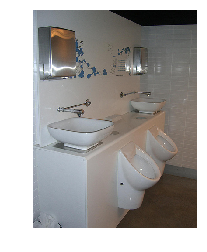

<START>         13.756556510925293
zoo             -26.471506118774414
with            -118.23981475830078
<UNK>           -164.3094482421875
and             -194.95050048828125
children        -201.96841430664062
<END>           -238.57559204101562
- - - -
Avg reward:  -75.2696089311


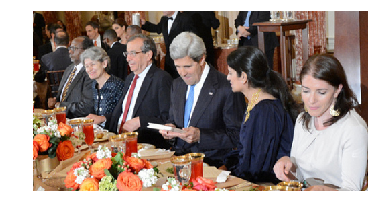

<START>         42.27627182006836
people          74.70709991455078
are             153.85406494140625
dining          138.107177734375
and             55.98134231567383
talking         -81.63714599609375
on              -197.65621948242188
a               -241.87359619140625
long            -254.00750732421875
table           -254.3460693359375
<END>           -263.3711242675781
- - - -


In [18]:
image_to_test = np.array([99, 1010])
captions_to_test = ["<START> zoo with monkey and children <END>".split(), "<START> people are dining and talking on a long table <END>".split()]
assign_reward(image_to_test, captions_to_test)

DEMO RESULTS
[620 346 808 691]
Avg reward:  -162.167


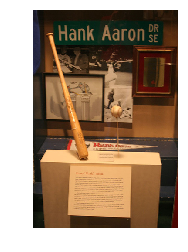

<START>         0.053991541266441345
<UNK>           -22.12905502319336
ball            -11.175926208496094
and             -112.60375213623047
bat             -158.71307373046875
on              -209.92974853515625
display         -236.65289306640625
in              -255.04718017578125
a               -257.88604736328125
<UNK>           -256.0654296875
<END>           -263.6910400390625
- - - -
Avg reward:  188.848


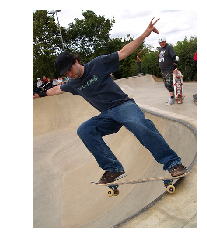

<START>         48.857948303222656
a               17.538585662841797
man             34.024986267089844
on              168.99710083007812
a               214.1914520263672
skateboard      233.6275634765625
riding          242.346435546875
up              256.643310546875
on              261.5792236328125
a               261.0075378417969
ledge           262.49798583984375
<END>           264.85888671875
- - - -
Avg reward:  -182.179


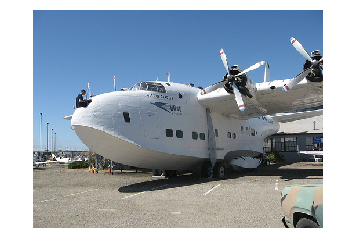

<START>         14.252589225769043
a               -8.44723892211914
man             -31.27193832397461
working         -146.58706665039062
by              -217.36553955078125
the             -246.9883575439453
<UNK>           -253.51608276367188
of              -258.2767028808594
a               -258.75115966796875
large           -259.2438049316406
<UNK>           -256.08392333984375
<END>           -263.86846923828125
- - - -
Avg reward:  192.925


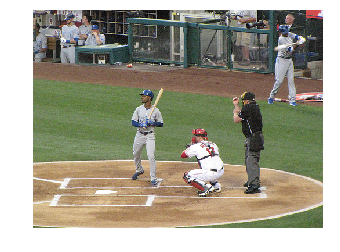

<START>         56.01032257080078
a               28.36478042602539
baseball        42.84496307373047
player          185.01893615722656
with            245.03089904785156
a               257.23260498046875
bat             257.938720703125
on              262.3469543457031
the             262.574951171875
field           260.1842346191406
<END>           264.62933349609375
- - - -


SAMPLED RESULTS
[1645 1851 1115 1915]
Avg reward:  -201.195


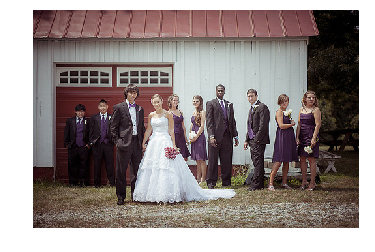

<START>         -38.55745315551758
a               -10.985147476196289
man             -26.353469848632812
on              -150.59295654296875
a               -223.67611694335938
motorcycle      -226.52825927734375
and             -255.52647399902344
a               -259.1642150878906
person          -255.541748046875
laying          -261.09783935546875
down            -263.1415100097656
by              -261.8380126953125
a               -261.6802978515625
building        -258.4833984375
<END>           -264.76470947265625
- - - -
Avg reward:  152.599


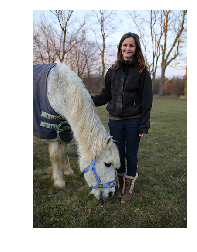

<START>         -23.686073303222656
a               6.712368011474609
baseball        -0.0035464614629745483
player          31.52753448486328
is              157.0506134033203
about           225.13134765625
to              251.79287719726562
swing           251.62539672851562
his             259.4384460449219
bat             255.85305786132812
<END>           263.1521301269531
- - - -
Avg reward:  194.555


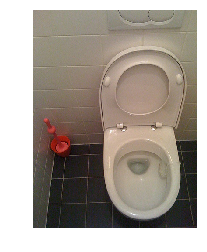

<START>         6.245544910430908
a               37.24941635131836
man             68.76698303222656
running         188.29409790039062
across          237.15505981445312
a               253.12478637695312
tennis          247.47128295898438
court           257.59466552734375
holding         257.85089111328125
a               258.9823913574219
racket          258.33355712890625
<END>           263.586669921875
- - - -
Avg reward:  204.523


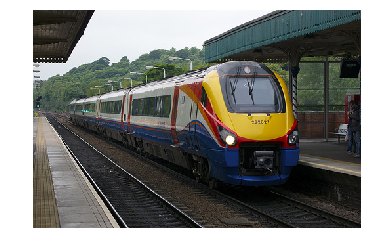

<START>         11.779330253601074
a               36.795501708984375
woman           66.54993438720703
sitting         189.52203369140625
in              239.21310424804688
a               253.85227966308594
car             253.24395751953125
with            260.50390625
a               258.54400634765625
black           258.8217468261719
and             261.3841552734375
white           258.93072509765625
cat             251.1881561279297
<END>           262.9880676269531
- - - -


In [26]:
examine_batch_results(demo_or_sampled_batch, image_idx_batch, caption_batch, m, me)

#### Bidirectional with tanh doesn't do well, it seems to assign all the tokens in that category (all 1 or all neg 1) after 600 iter / 2000 bath size
#### Bidirectional without tanh seems to do qualitatively better - needs a metric that can compare across different methods
#### Uni-directional with difference of hidden states make results more discriminative at word levels
#### Bidirectional with difference of hidden states are also more disciminative

In [20]:
diff_func = lambda x1, x2 : x2-x1
tf.scan(diff_func, tf.constant([[12,3],[8,9]])).eval()

array([[12,  3],
       [-4,  6]], dtype=int32)